In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize,BoundaryNorm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from scipy.sparse import lil_matrix
import random

In [61]:
 class population():
    def __init__(self,N = 100,duration = 100,transmission_time = 7,imunity_time = 7,r_0 = 0.01,infection_rate = 0.3,mortality_rate = 0.03,sociability = 4,daily_contact_rate = 0.5):
        self.N = N                             # defining all parameters and initializing the world
        self.duration = duration
        self.transmission_time = transmission_time
        self.imunity_time = imunity_time
        self.sociability = sociability
        self.mortality_rate = mortality_rate
        self.daily_contact_rate = daily_contact_rate
        self.r_0 = r_0
        self.infection_rate = infection_rate
        self.history = []
        self.per = []
        self.death = []
        self.world = np.zeros((N, N), dtype=[('health', 'float32'), ('status', 'uint8'), ('timer', 'int32')])
        self.world['health'] = np.random.uniform(0.5, 1, (N, N))
        self.world['timer'] = -imunity_time   # the world is created through a two dimensional structered array with the three fields healt,status,timer
        for _ in range(round(r_0*N**2)):  
            i,j = np.random.randint(N),np.random.randint(N)
            self.world['status'][i,j] = 1   # set status
            self.world['timer'][i,j] = self.transmission_time # set time to transmit disease
        self.infection_chance_matrices = [np.random.uniform(0, 0.5, (2 * self.sociability + 1, 2 * self.sociability + 1)) for _ in range(3000)]
        self.contact_sphere = [np.random.uniform(0,1,(2 * self.sociability + 1, 2 * self.sociability + 1)) < self.daily_contact_rate for _ in range(3000)]
    
    def neighbourhood(self,x,y):
        start_y = (y - self.sociability) % self.N
        end_y = (y + self.sociability + 1) % self.N
        start_x = (x - self.sociability) % self.N
        end_x = (x + self.sociability + 1) % self.N
        # Check if wrapping is needed
        if start_y > end_y:
            sub_world_y = np.concatenate([self.world[start_y:], self.world[:end_y]], axis=0)
        else:
            sub_world_y = self.world[start_y:end_y]
        if start_x > end_x:
            sub_world = np.concatenate([sub_world_y[:, start_x:], sub_world_y[:, :end_x]], axis=1)
        else:
            sub_world = sub_world_y[:, start_x:end_x]
            
        return sub_world['health'], sub_world['status'], sub_world['timer']

    def susceptibility(self,health_matrix, status_matrix, recovery_matrix):
        susceptible_condition = (status_matrix == 0) & (recovery_matrix < -self.imunity_time) & (random.choice(self.contact_sphere))
        infection_chance_matrix = random.choice(self.infection_chance_matrices)[:health_matrix.shape[0], :health_matrix.shape[1]]
        return susceptible_condition, infection_chance_matrix
        
    def infect(self,health_matrix, status_matrix, susceptible_condition, infection_chance_matrix):
        infection_chance = health_matrix - infection_chance_matrix  # Apply the random transmission factor
        infection_condition = infection_chance < self.infection_rate
        new_infections = infection_condition & susceptible_condition
        new_diseased = infection_condition & (infection_chance < self.infection_rate*self.mortality_rate)
        return new_infections, new_diseased
        
    def sim(self):
        %matplotlib notebook
        t = 0
        dt = 1
        while t < self.duration:
            infected_indices = np.where(self.world['status'] == 1)
            for x,y in zip(*infected_indices):
                health_matrix, status_matrix, recovery_matrix = self.neighbourhood(x,y)
                susceptible_condition, infection_chance_matrix = self.susceptibility(health_matrix, status_matrix, recovery_matrix)
                new_infections, new_diseased = self.infect(health_matrix, status_matrix, susceptible_condition, infection_chance_matrix)
                status_matrix[new_infections] = 1
                recovery_matrix[new_infections] = self.transmission_time * (2 / (3*health_matrix[self.sociability,self.sociability]))
                status_matrix[new_diseased] = 2
            self.world['timer'] -= 1
            self.world['status'][(self.world['status'] == 1) & (self.world['timer'] < 0)] = 0
            self.history.append(lil_matrix(self.world['status']))
            death_tally = np.sum(self.world['status'] == 2)
            self.per.append(np.sum(self.world['status'] == 1) / (self.N*self.N - death_tally) * 100)
            self.death.append(death_tally/(self.N*self.N) * 100)
            t += dt

        #Animation 
        cmap = ListedColormap(['white', 'red', 'black'])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N) 
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]})
        gs = GridSpec(1, 3, width_ratios=[8, 1, 1])
        ax1,ax2,ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])
        plot = ax1.imshow(self.history[0].toarray(), cmap=cmap, norm=norm)
        time_text = ax1.text(0.4,  1.05, '', transform=ax1.transAxes, color='black')
        for ax in (ax1,ax2,ax3):
            ax.set_xticks([])
            ax.set_yticks([])
        infected_bar = ax2.bar(0, 0, color='red')
        diseased_bar = ax3.bar(0, 0, color='black')
        ax2.set_ylim(0, 100), ax3.set_ylim(0, 100)
        ax2.set_title('Infected (%)',fontsize=7), ax3.set_title('Diseased (%)',fontsize=7)
        def animate(i):
            plot.set_data(self.history[i].toarray())
            time_text.set_text('Day:  %.1f' % i )
            bar_inf = infected_bar[0]
            bar_dis = diseased_bar[0]
            bar_inf.set_height(self.per[i])
            bar_dis.set_height(self.death[i])
            return plot, time_text, bar_inf,bar_dis
        animation = FuncAnimation(fig,
                              func = animate,
                              frames = np.arange(len(self.history)), 
                              interval = 150)
        return animation

<IPython.core.display.Javascript object>


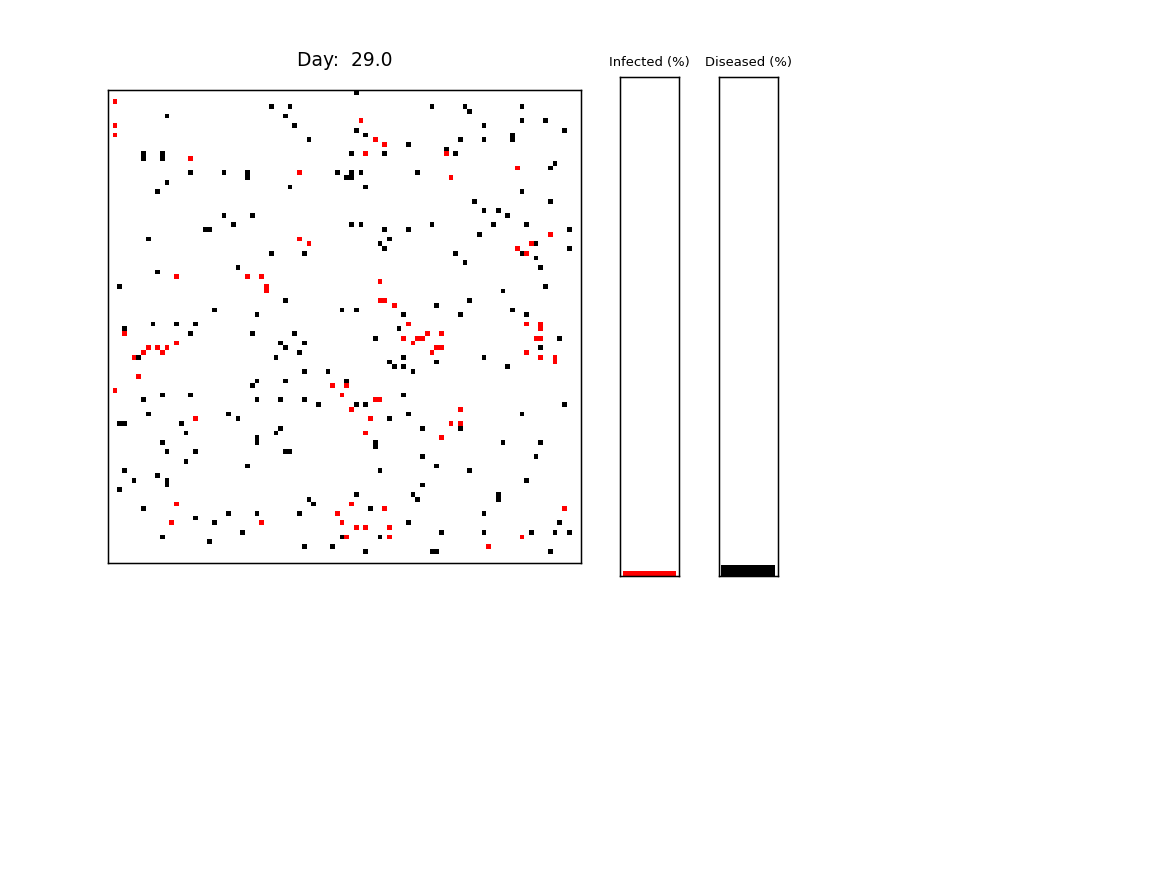

In [60]:
example = population(N = 100, duration = 100, r_0 = 0.01, infection_rate = 0.3, transmission_time=7, 
                  imunity_time=14, sociability = 3, mortality_rate = 0.05,daily_contact_rate=0.1)

example.sim()

# Profiler

<IPython.core.display.Javascript object>


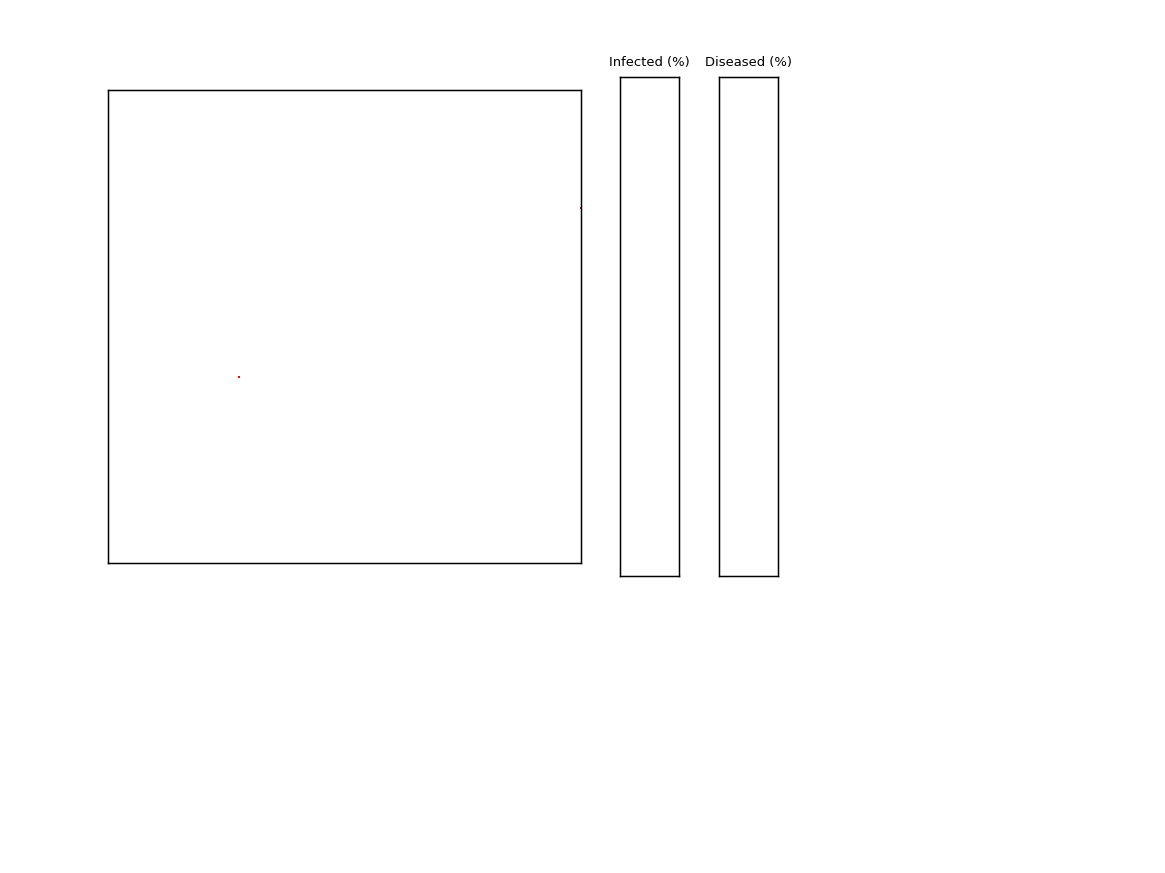

         2900507 function calls (2897131 primitive calls) in 9.884 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   186756    3.057    0.000    4.156    0.000 <ipython-input-51-9f54c7f11560>:41(susceptibility)
   186756    2.054    0.000    2.054    0.000 <ipython-input-51-9f54c7f11560>:46(infect)
   186756    1.354    0.000    1.492    0.000 <ipython-input-51-9f54c7f11560>:24(neighbourhood)
        1    1.333    1.333    9.883    9.883 <ipython-input-51-9f54c7f11560>:53(sim)
   373512    0.452    0.000    1.099    0.000 random.py:285(choice)
   373512    0.399    0.000    0.573    0.000 random.py:250(_randbelow_with_getrandbits)
       60    0.176    0.003    0.177    0.003 cycler.py:349(by_key)
7988/7748    0.159    0.000    0.199    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   509956    0.104    0.000    0.104    0.000 {method 'getrandbits' of '_random.Random' objects}
   380947    0

       96    0.000    0.000    0.016    0.000 ticker.py:2909(__init__)
      224    0.000    0.000    0.001    0.000 re.py:289(_compile)
       14    0.000    0.000    0.010    0.001 comm.py:61(_publish_msg)
      200    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(empty_like)
       63    0.000    0.000    0.001    0.000 path.py:193(_update_values)
     1400    0.000    0.000    0.000    0.000 {built-in method _operator.index}
       32    0.000    0.000    0.001    0.000 _base.py:3197(_validate_converted_limits)
   174/90    0.000    0.000    0.002    0.000 _base.py:700(get_xaxis_transform)
      236    0.000    0.000    0.000    0.000 {method 'astype' of 'numpy.ndarray' objects}
       24    0.000    0.000    0.167    0.007 axis.py:1401(grid)
      460    0.000    0.000    0.000    0.000 font_manager.py:1016(_normalize_font_family)
       33    0.000    0.000    0.001    0.000 patches.py:400(set_linestyle)
       18    0.000    0.000    0.002    0.000 markers.

      200    0.000    0.000    0.000    0.000 multiarray.py:80(empty_like)
        7    0.000    0.000    0.000    0.000 traitlets.py:1540(_get_trait_default_generator)
       12    0.000    0.000    0.008    0.001 backend_webagg_core.py:343(send_event)
       13    0.000    0.000    0.000    0.000 artist.py:1008(set_label)
       28    0.000    0.000    0.000    0.000 threading.py:1017(_wait_for_tstate_lock)
        9    0.000    0.000    0.000    0.000 transforms.py:946(intervaly)
      186    0.000    0.000    0.000    0.000 ticker.py:304(_set_locator)
       26    0.000    0.000    0.000    0.000 text.py:524(_update_clip_properties)
        6    0.000    0.000    0.000    0.000 _base.py:2815(set_axisbelow)
        1    0.000    0.000    0.018    0.018 pyplot.py:555(figure)
       17    0.000    0.000    0.000    0.000 {built-in method builtins.locals}
       11    0.000    0.000    0.000    0.000 transforms.py:1794(transform_affine)
       18    0.000    0.000    0.000    0.000 {bu

        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(ravel_multi_index)
        7    0.000    0.000    0.000    0.000 figure.py:194(update)
       24    0.000    0.000    0.000    0.000 pretty.py:305(_get_mro)
        1    0.000    0.000    0.000    0.000 figure.py:1784(clf)
       16    0.000    0.000    0.000    0.000 getlimits.py:562(tiny)
       16    0.000    0.000    0.000    0.000 {built-in method nt.getpid}
       50    0.000    0.000    0.000    0.000 {method 'items' of 'mappingproxy' objects}
        6    0.000    0.000    0.000    0.000 inspect.py:2489(__init__)
        9    0.000    0.000    0.000    0.000 figure.py:92(<dictcomp>)
       20    0.000    0.000    0.000    0.000 axis.py:1509(have_units)
        4    0.000    0.000    0.000    0.000 pathlib.py:717(__str__)
        6    0.000    0.000    0.000    0.000 traitlets.py:615(_cross_validate)
     12/4    0.000    0.000    0.000    0.000 transforms.py:2333(<lambda>)
        1    0.000    0.0

        2    0.000    0.000    0.000    0.000 core.py:3407(dtype)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        4    0.000    0.000    0.000    0.000 {method 'split' of 'str' objects}
       14    0.000    0.000    0.000    0.000 pretty.py:102(_safe_getattr)
        2    0.000    0.000    0.000    0.000 pretty.py:297(flush)
        2    0.000    0.000    0.000    0.000 __init__.py:552(__init__)
        1    0.000    0.000    0.000    0.000 _pylab_helpers.py:79(destroy_all)
        1    0.000    0.000    0.000    0.000 animation.py:938(__init__)
        1    0.000    0.000    0.000    0.000 cm.py:466(changed)
        4    0.000    0.000    0.000    0.000 pretty.py:168(group)
        6    0.000    0.000    0.000    0.000 pathlib.py:1048(_init)
        2    0.000    0.000    0.000    0.000 display.py:34(_safe_exists)
        3    0.000    0.000    0.000    0.000 rcsetup.py:292(validate_backend)
        2    0.000    0.000    0.000    0.000 {built-in 

        2    0.000    0.000    0.000    0.000 __init__.py:1830(_str_equal)
        1    0.000    0.000    0.000    0.000 image.py:788(set_resample)
        1    0.000    0.000    0.000    0.000 __init__.py:1200(interactive)
        2    0.000    0.000    0.000    0.000 traitlets.py:2251(validate)
        2    0.000    0.000    0.000    0.000 pathlib.py:101(join_parsed_parts)
        2    0.000    0.000    0.000    0.000 interactiveshell.py:3334(compare)
        2    0.000    0.000    0.000    0.000 gridspec.py:120(set_height_ratios)
        2    0.000    0.000    0.000    0.000 {built-in method from_bytes}
        5    0.000    0.000    0.000    0.000 {method 'values' of 'collections.OrderedDict' objects}
        1    0.000    0.000    0.000    0.000 comm.py:137(on_msg)
        4    0.000    0.000    0.000    0.000 artist.py:1043(sticky_edges)
        4    0.000    0.000    0.000    0.000 path.py:694(unit_rectangle)
        2    0.000    0.000    0.000    0.000 widgets.py:35(__init__)


        1    0.000    0.000    0.000    0.000 traitlets.py:2137(validate)
        1    0.000    0.000    0.000    0.000 argparse.py:2116(<listcomp>)
        2    0.000    0.000    0.000    0.000 formatters.py:824(_check_return)
        1    0.000    0.000    0.000    0.000 artist.py:959(set_in_layout)
        3    0.000    0.000    0.000    0.000 {function Config.__contains__ at 0x0000029EAC673820}
        1    0.000    0.000    0.000    0.000 {method 'clear' of 'collections.OrderedDict' objects}
        1    0.000    0.000    0.000    0.000 {built-in method _ctypes.byref}
        4    0.000    0.000    0.000    0.000 transforms.py:1741(get_affine)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.globals}
        1    0.000    0.000    0.000    0.000 traitlets.py:1166(compress)
        1    0.000    0.000    0.000    0.000 argparse.py:1240(__init__)
        1    0.000    0.000    0.000    0.000 display.py:645(_data_and_metadata)
        1    0.000    0.000    0.0

In [54]:
import cProfile
example = population(N = 200, duration = 100, r_0 = 0.01, infection_rate = 0.1, transmission_time=7, 
                  imunity_time=7, sociability = 3, mortality_rate = 0.05)
profiler = cProfile.Profile()
profiler.enable()
example.sim()
profiler.disable()
# Display results
profiler.print_stats(sort='time')

In [53]:
print(random.choice([0,1,2,3,4]))

1
